In [1]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from copy import *
from sklearn.metrics import root_mean_squared_error

from surprise import SVD, NMF
from surprise import Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.reader import Reader
%load_ext autoreload
%autoreload 2

In [ ]:
# import DB et set min_reviews

folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"trictrac_database/users.csv", index_col=0)

min_reviews = 10 # change to set one
rev_filter = filter_df(avis_clean, min_reviews)

# create user-game matrix
#user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
SPLITS=5

11201 10549
2086 2464
1800 2399
1792 2397
1791 2396


### Perform cross-validation to choose `n_components`

In [ ]:
# ranks = np.arange(5, 70, step=5)
# results = []
# SPLITS = 5
# for rank in ranks:
#     nmf = NMF(n_factors=rank, random_state=1)
#     results.append(cross_validate(nmf, data, measures=["RMSE", "MAE"], cv=SPLITS, verbose=True))

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.6623  3.6588  3.6801  3.6679  3.6645  3.6667  0.0073  
MAE (testset)     3.2869  3.2754  3.3049  3.2960  3.2858  3.2898  0.0100  
Fit time          0.51    0.57    0.57    0.48    0.47    0.52    0.04    
Test time         0.03    0.03    0.06    0.03    0.06    0.04    0.02    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.9299  2.9543  2.9522  2.9651  2.9600  2.9523  0.0121  
MAE (testset)     2.5445  2.5774  2.5682  2.5841  2.5751  2.5698  0.0137  
Fit time          0.54    0.55    0.54    0.56    0.54    0.54    0.01    
Test time         0.03    0.03    0.07    0.03    0.06    0.04    0.02    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset

Add data for `DataFrame` generation

In [ ]:
# res_copy = deepcopy(results)
# for d, k in zip(res_copy, ranks):
#     d['k'] = [k] * SPLITS
#     d["mean_rmse"] = np.mean(d["test_rmse"])
#     d["mean_mae"] = np.mean(d["test_mae"])

{'test_rmse': array([3.66228132, 3.65879356, 3.68005663, 3.66785839, 3.66445368]),
 'test_mae': array([3.28685475, 3.27535672, 3.30494152, 3.29596796, 3.28577601]),
 'fit_time': (0.5139009952545166,
  0.5738940238952637,
  0.5700669288635254,
  0.4791600704193115,
  0.47078490257263184),
 'test_time': (0.0263369083404541,
  0.027708053588867188,
  0.061979055404663086,
  0.026123046875,
  0.0621790885925293),
 'k': [5, 5, 5, 5, 5],
 'mean_rmse': 3.6666887157849777,
 'mean_mae': 3.289779389252898}

Create / load `DataFrame` to plot

In [25]:
# rmse = np.array([d["test_rmse"] for d in results])
# mae = np.array([d["test_mae"] for d in results])

# df=pd.json_normalize(res_copy) 
# df = df.apply(lambda x: x.explode()).reset_index(drop=True)
df = pd.read_csv("generated_data/NNMF_rmse_mae.csv", index_col=0)
df_means = df[["mean_rmse", "mean_mae", "k"]].drop_duplicates()

### Plot RMSE

Text(0, 0.5, 'RMSE')

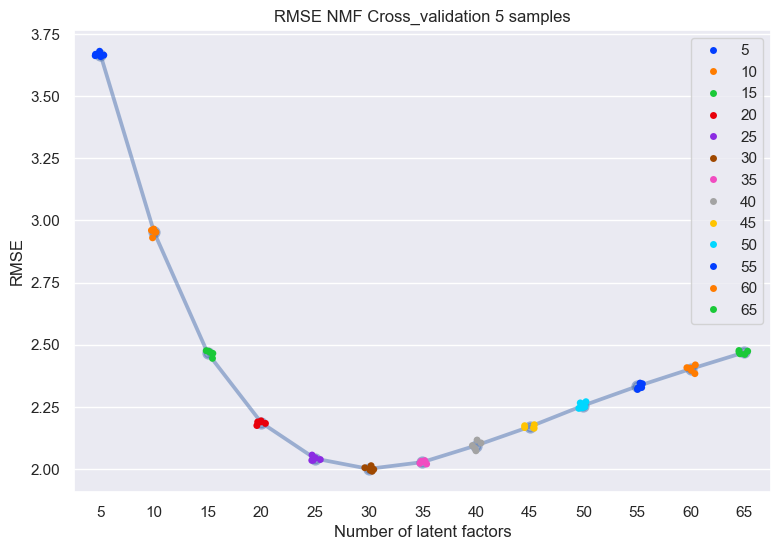

In [23]:
sns.set_theme(rc={'figure.figsize':(9,6)})
#ax = sns.boxplot(data=df, x="k", y="test_rmse", width=.5, whis=(0, 100))
ax = sns.stripplot(data=df, x="k", y="test_rmse", hue="k", palette="bright")
sns.pointplot(data=df, x="k", y="mean_rmse", alpha=0.5)
ax.set_title(f"RMSE NMF Cross_validation {SPLITS} samples")
ax.set_xlabel("Number of latent factors")
ax.set_ylabel("RMSE")

### Plot MAE

Text(0, 0.5, 'MAE')

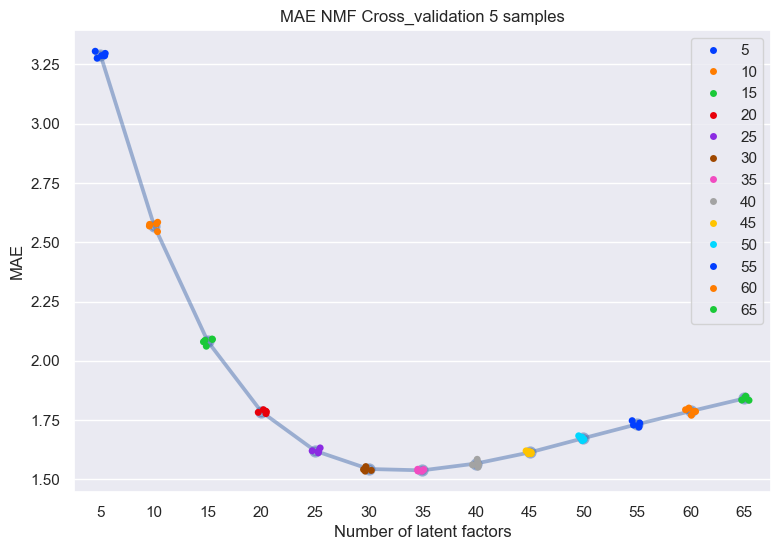

In [24]:
sns.set_theme(rc={'figure.figsize':(9,6)})
#ax = sns.boxplot(data=df, x="k", y="test_rmse", width=.5, whis=(0, 100))
ax = sns.stripplot(data=df, x="k", y="test_mae", hue="k", palette="bright")
sns.pointplot(data=df, x="k", y="mean_mae", alpha=0.5)
ax.set_title(f"MAE NMF Cross_validation {SPLITS} samples")
ax.set_xlabel("Number of latent factors")
ax.set_ylabel("MAE")

### Plot $H$, $W$ matrices for $30$ components (best rmse, mae)

In [26]:
trainset, testset = train_test_split(data, test_size=0.2)

# Train NMF model
nmf = NMF(n_factors=30, random_state=1)
nmf.fit(trainset)

# Extract matrices
W = nmf.pu  # User-feature matrix (W)
H = nmf.qi  # Item-feature matrix (H)

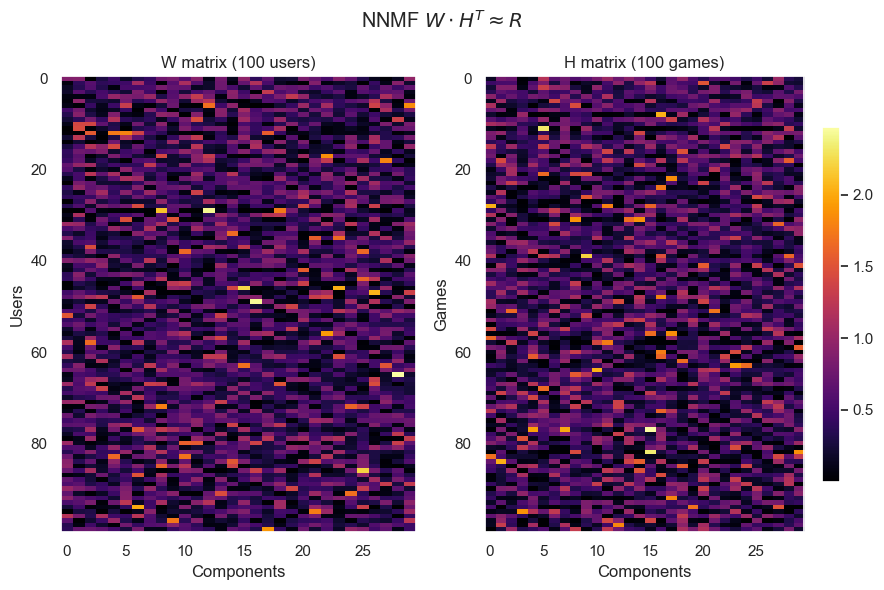

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)

Wim = ax1.imshow(W[:100, :], aspect='auto', cmap="inferno")
ax1.set_xlabel("Components")
ax1.set_ylabel("Users")
ax1.set_title("W matrix (100 users)")
ax1.grid(False)

Him = ax2.imshow(H[:100, :], aspect='auto', cmap="inferno")
ax2.set_xlabel("Components")
ax2.set_ylabel("Games")
ax2.set_title("H matrix (100 games)")
ax2.grid(False)

fig.colorbar(Him, fraction=0.05)
fig.suptitle(r"NNMF $W \cdot H^T \approx R$")
fig.set_size_inches(9, 6)
plt.tight_layout()